In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
base_dir = pathlib.Path("/content/drive/MyDrive/dataset") #path dataset

In [ ]:
IMAGE_SIZE = 180
BATCH_SIZE = 64

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

In [ ]:
train_dataset = datagen.flow_from_directory(
    base_dir/'train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,

)
validation_dataset = datagen.flow_from_directory(
    base_dir/ 'validation',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

test_dataset = datagen.flow_from_directory(
    base_dir/ 'test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
train_dataset.class_indices

{'benign': 0, 'malignent': 1}

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) #180,180, RGB
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable=False

In [ ]:
# data_augmentation = keras.Sequential(
# [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.2),
# ])

In [ ]:
model = tf.keras.Sequential([
  base_model,
  # data_augmentation,
  tf.keras.layers.Conv2D(32,3, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
     loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, to_file = 'model.jpg', show_shapes = True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= base_dir / "MobileNetV3Large.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs= 30 ,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
13/13 [==============================] - 283s 23s/step - loss: 12.5020 - accuracy: 0.6050 - val_loss: 0.8960 - val_accuracy: 0.5025
Epoch 2/30
13/13 [==============================] - 5s 350ms/step - loss: 0.5855 - accuracy: 0.5000 - val_loss: 0.5128 - val_accuracy: 0.5000
Epoch 3/30
13/13 [==============================] - 5s 354ms/step - loss: 0.5097 - accuracy: 0.8062 - val_loss: 0.5609 - val_accuracy: 0.7975
Epoch 4/30
13/13 [==============================] - 5s 421ms/step - loss: 0.4699 - accuracy: 0.8562 - val_loss: 0.4804 - val_accuracy: 0.8600
Epoch 5/30
13/13 [==============================] - 5s 360ms/step - loss: 0.4348 - accuracy: 0.8913 - val_loss: 0.4625 - val_accuracy: 0.8625
Epoch 6/30
13/13 [==============================] - 5s 385ms/step - loss: 0.3922 - accuracy: 0.9175 - val_loss: 0.4290 - val_accuracy: 0.8800
Epoch 7/30
13/13 [==============================] - 5s 352ms/step - loss: 0.3561 - accuracy: 0.9350 - val_loss: 0.4167 - val_accuracy: 0.8875
Epoch

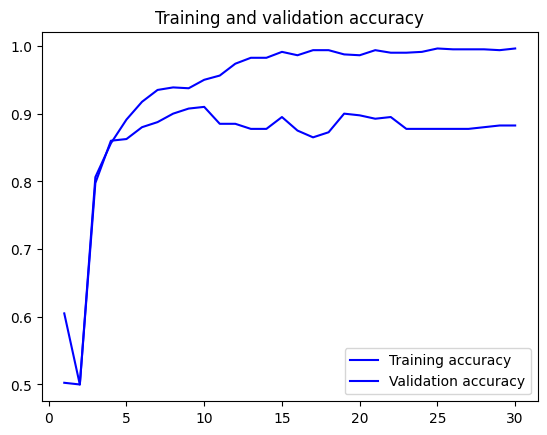

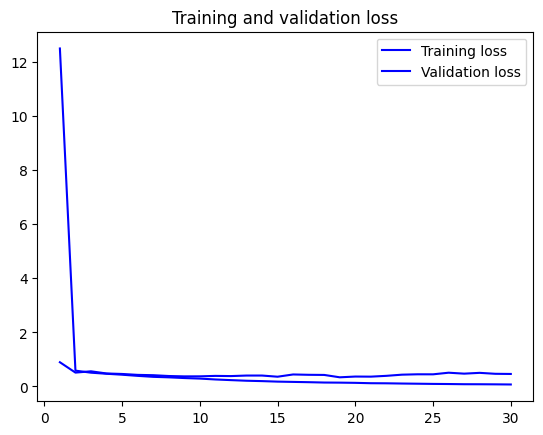

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model_2 = keras.models.load_model(base_dir /  "MobileNetV3Large.keras")
test_loss, test_acc = test_model_2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 389s 43s/step - loss: 0.4741 - accuracy: 0.8050
Test accuracy: 0.805


### Create file label.txt and convert file model to tflite

In [ ]:
import os #for file management
from google.colab import files


In [ ]:
print(train_dataset.class_indices)
labels = '\n'.join(sorted(train_dataset.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'benign': 0, 'malignent': 1}


In [ ]:
model = tf.keras.models.load_model(base_dir/"MobileNetV3Large.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( 'model.tflite' , 'wb' )
file.write( tflmodel )

10341704

In [ ]:
files.download('model.tflite')
files.download('labels.txt')